## ADAPTIVE CONVULATION MODEL FOR NEURAL STYLE TRANSFER
--research paper link - https://openaccess.thecvf.com/content/CVPR2021/papers/Chandran_Adaptive_Convolutions_for_Structure-Aware_Style_Transfer_CVPR_2021_paper.pdf

-- "Adaptive Convolutions (AdaConv) model is a generic extension of AdaIN, to allow for the simultaneous
transfer of both statistical and structural styles in real time." I chose this research paper because this is very less worked research paper, suggesting good results and have only one implementation available on the internet(as far as google search is concerned), so that I can display my implementation skill and understanding of any research.


**All the layers, loss functions are according to above research paper only.You can check & read it for details**

Keshav Mandowra
20111024
IITR
keshav_m@me.iitr.ac.in
+918094474288



Install the following required libraries(requirements.txt is provided)

In [22]:
#pip freeze > requirements.txt
#uncomment the following line & delete the first line before running on a new environment
#pip install --requirements.txt

Import the needed libraries

In [23]:
#standard libraries
import os
import sys
import warnings
from argparse import ArgumentParser
from pathlib import Path
from IPython.display import display


#numpy and pandas for data operations and handling
import numpy as np
import pandas as pd
from math import ceil, floor
from math import sqrt
from statistics import mean


#for random number generation
import random

#For plotting with matplotlib
import matplotlib.pyplot as plt
#For plotting with seaborn
import seaborn as sns  
#For plotting with plotly
import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

#for train-test split & normalization
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


#for image processing
import cv2
from PIL import Image

#pytorch torchvison library and their functions/classes
import torch 
from torch import nn
from torch import Tensor
from torch.nn import functional as F
from torch.utils.data import IterableDataset, Dataset
from torch.utils import get_cpp_backtrace
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from torchvision.transforms import RandomCrop, CenterCrop, Resize, ToTensor, Compose
from torch.optim import Adam
from torch.optim.lr_scheduler import LambdaLR
from torchvision.utils import make_grid
from torchvision import transforms
from torchvision import models

#wrapper for pytorch model--makes our process easy
import pytorch_lightning as pl



Files in current directory

In [24]:
cwd=os.getcwd()

print("Files in the current working directory:",[cwd],"are--", ', '.join(os.listdir()),'\n')

img_path = os.path.join(cwd, "img_train_data")
print("Image content data is stored at:", img_path,'\n')
style_path =  os.path.join(cwd, "style_data")
print("Style's data is stored at:", style_path,'\n')


Files in the current working directory: ['C:\\Users\\kesha\\Desktop\\Untitled Folder 1'] are-- .ipynb_checkpoints, 370865.webp, Dashtoon CNN.ipynb, gdngd-Copy1.ipynb, gdngd.ipynb, img_train_data, logs, model.ckpt, New folder, preserve.ipynb, requirements.txt, style_data, style_data_1, temp_image.png, temp_image0.png, temp_image1.png, test_images, Untitled.ipynb 

Image content data is stored at: C:\Users\kesha\Desktop\Untitled Folder 1\img_train_data 

Style's data is stored at: C:\Users\kesha\Desktop\Untitled Folder 1\style_data 



There are 118287 image-content files from **COCO 2014 train dataset** 34984 style files from **WIKI ART dataset** 

COCO 2014 link - https://cocodataset.org/#download


Wiki Art link - http://web.fsktm.um.edu.my/~cschan/source/ICIP2017/wikiart.zip

In [29]:
from collections import Counter

def count_files_and_types(directory):
    # Get the list of files in the directory
    files = os.listdir(directory)

    # Filter out subdirectories
    files = [f for f in files if os.path.isfile(os.path.join(directory, f))]

    # Extract file extensions
    file_types = [os.path.splitext(file)[1] for file in files]

    # Count the occurrences of each file type
    file_types_counter = Counter(file_types)

    # Display the results
    print(f"Number of files in {directory}: {len(files)}")
    print("\nFile types:") 
    for file_type, count in file_types_counter.items():
        print(f"{file_type}: {count} files\n")

# Call the function
count_files_and_types(img_path)
count_files_and_types(style_path)


Number of files in C:\Users\kesha\Desktop\Untitled Folder 1\img_train_data: 118282

File types:
.jpg: 118282 files

Number of files in C:\Users\kesha\Desktop\Untitled Folder 1\style_data: 34983

File types:
.jpg: 34983 files



Now let's define some python function which will be useful in loading/saving/transforming/analysing data

In [5]:

def get_files_from(directory):
    try:
        # Check if the directory exists and is valid
        if not os.path.exists(directory) or not os.path.isdir(directory):
            raise ValueError("Invalid directory path")

        # Return sorted list of file paths
        return sorted([os.path.join(directory, file) for file in os.listdir(directory)])
    except Exception as e:
        print(f"Error: {e}")
        return []

img_files = get_files_from(img_path)
style_files = get_files_from(style_path)

def identity_function(x):
    return x


def convert_to_rgb(image_path):
    try:
        # Open the image file
        img = Image.open(str(image_path))
        
        # Check if the image is not in 'RGB' mode
        if img.mode != 'RGB':
            # Convert the image to RGB mode
            rgb_image = img.convert('RGB')
            print(f"Image converted to RGB mode: {image_path}")
            return rgb_image
        else:
            return img

    except FileNotFoundError:
        print(f"Error: File not found - {image_path}")
        return None

    except Exception as e:
        print(f"Error: {e}")
        return None

    
def preprocess_style(target_size=256):
    """
    Preprocess a art image with common transformations.

    Parameters:
    - target_size (int): The target size for the square image.

    Returns:
    - transform (Compose): A composition of transformations to be applied to the art .
    """
    transformations = [
        Resize(size=target_size),  # Resize while maintaining aspect ratio
        CenterCrop(size=(target_size, target_size)),  # Center crop to make it square
        ToTensor()  # Convert to PyTorch tensor
    ]

    return Compose(transformations)


def preprocess_content(target_size=None):
    """
    Preprocess image with optional resizing.

    Parameters:
    - target_size (int or tuple): The target size for the image. If provided, the image is resized.

    Returns:
    - transform (Compose): A composition of transformations to be applied to the content image.
    """
    transformations = []

    if target_size:
        transformations.append(Resize(size=target_size))  # Resize if target_size is specified

    transformations.append(ToTensor())  # Convert to PyTorch tensor

    return Compose(transformations)


def save_image_tensor(image_tensor, file_path):
    """
    Save a PyTorch tensor representing an image to a file.

    Parameters:
    - image_tensor (torch.Tensor): The PyTorch tensor representing the image.
    - file_path (str): The file path where the image should be saved.

    Raises:
    - ValueError: If the input tensor has an unexpected number of dimensions.

    Notes:
    - If the tensor has 4 dimensions, it is expected to represent a batch with a single image.
    """
    try:
        # Ensure image_tensor is a PyTorch tensor
        if not torch.is_tensor(image_tensor):
            raise ValueError("Input must be a PyTorch tensor.")

        # Ensure the tensor has 3 or 4 dimensions
        if image_tensor.ndim not in {3, 4}:
            raise ValueError("Input tensor must be 3D (single image) or 4D (batch with a single image).")

        # If 4D tensor, ensure it represents a batch with a single image
        if image_tensor.ndim == 4 and image_tensor.size(0) != 1:
            raise ValueError("For a 4D tensor, the batch size must be 1.")

        # Save the image
        save_image(image_tensor, str(file_path))
        print(f"Image saved successfully to: {file_path}")

    except ValueError as ve:
        print(f"Error: {ve}")



Let's visualize some characterstics of data

In [6]:
from IPython.display import Image, display, HTML
from PIL import Image as PILImage

# Assuming img_files is an array of image file paths
img_idx = [7, 8]

# Load and resize the images
images = [PILImage.open(img_files[1]).resize((300, 300)),PILImage.open(style_files[14]).resize((300, 300))]


# Create an HTML container for the images with CSS styling for horizontal arrangement
html_content = "<div style='display: flex;'>"
i=0
for img in images:
    img_path = f'temp_image{i}.png'
    img.save(img_path)
    i=i+1
    html_content += f"<img src='{img_path}' style='margin-right: 10px;'>"
html_content += "</div>"

# Display the HTML content
display(HTML(html_content))


A content image v/s a style image in the above output. We want to transfer the style of style image to the content image

In [7]:

root_path = cwd

# Initialize empty lists to store the information
sizes = []
resolutions = []
color_distributions = []
i=0


for filename in img_files[0:10000]:
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            # Load the image file using OpenCV
            imgg_path = os.path.join(img_path, filename)
            img = cv2.imread(imgg_path)

            # Extract the size of the image
            size = os.path.getsize(imgg_path)
            sizes.append(size)

            # Extract the resolution of the image
            resolution = img.shape[:2]
            resolutions.append(resolution)

            # Extract the color distribution of the image
            color_distribution = np.bincount(img.flatten(), minlength=256)
            color_distributions.append(color_distribution)

# Convert the lists to numpy arrays for easier manipulation
sizes = np.array(sizes)
resolutions = np.array(resolutions)
color_distributions = np.array(color_distributions)



In [8]:
# Assuming 'sizes' is a numpy array

# Create a histogram using Plotly
fig = go.Figure()

fig.add_trace(go.Histogram(x=sizes, nbinsx=50,  # Adjust the number of bins
                            marker_color='green',  # You can customize the color
                            opacity=0.7))

# Customize the layout
fig.update_layout(title="Distribution of Content Image Sizes",
                  xaxis_title="File Size (bytes)",
                  yaxis_title="Number of Images",
                  bargap=0.05)  # Adjust the gap between bars

# Show the plot
fig.show()


In [9]:
resolutions_df = pd.DataFrame(resolutions, columns=['Width', 'Height'])

# Plot a scatter plot using Plotly Express
fig = px.scatter(resolutions_df, x='Width', y='Height', title="Distribution of Content Image Resolutions",
                 labels={"x": "Width (pixels)", "y": "Height (pixels)"})
fig.show()

In [10]:

# Assuming 'mean_color_distribution' is a numpy array with shape (256,)

# Create a bar chart using Plotly
fig = go.Figure()

fig.add_trace(go.Bar(x=np.arange(256), y=color_distribution,
                     marker_color='blue',  # You can customize the color
                     opacity=0.7))

# Customize the layout
fig.update_layout(title="Mean Color Distribution of Content Images",
                  xaxis_title="Color Value",
                  yaxis_title="Number of Pixels",
                  bargap=0.05,  # Adjust the gap between bars
                  showlegend=False)  # Hide legend for a single trace

# Show the plot
fig.show()


In [33]:
#cleared output due to size issue
#one can run and check details of style files
root_path = cwd

# Initialize empty lists to store the information
s_sizes = []
s_resolutions = []
s_color_distributions = []

style_files= get_files_from(style_path)

i=0



for filename in style_files[0:10000]:
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            # Load the image file using OpenCV
            stylee_path = os.path.join(style_path, filename)
            
            img = cv2.imread(stylee_path)
            # Extract the size of the image
            size = os.path.getsize(stylee_path)
            s_sizes.append(size)

            # Extract the resolution of the image
            try:
                s_resolution = img.shape[:2]
                s_resolutions.append(resolution)
            except :
                pass
        

            # Extract the color distribution of the image
            try:
                    s_color_distribution = np.bincount(img.flatten(), minlength=256)
                    s_color_distributions.append(s_color_distribution)
            except:
                pass

In [ ]:
s_resolutions_df = pd.DataFrame(s_resolutions, columns=['Width', 'Height'])

# Plot a scatter plot using Plotly Express
fig = px.scatter(s_resolutions_df, x='Width', y='Height', title="Distribution of Style Image Resolutions",
                 labels={"x": "Width (pixels)", "y": "Height (pixels)"})
fig.show()

In [ ]:
# Assuming 's_sizes' is a numpy array

# Create a histogram using Plotly
fig = go.Figure()

fig.add_trace(go.Histogram(x=s_sizes, nbinsx=50,  # Adjust the number of bins
                            marker_color='green',  # You can customize the color
                            opacity=0.7))

# Customize the layout
fig.update_layout(title="Distribution of Style Image Sizes",
                  xaxis_title="File Size (bytes)",
                  yaxis_title="Number of Images",
                  bargap=0.05)  # Adjust the gap between bars

# Show the plot
fig.show()


In [27]:
# Specify the minimum size (optional, set to None if not needed)
min_size = None  # Change this to the desired minimum size or set to None

# Create the Compose object with specified transformations
img_transform = Compose([
  Resize(size=(512, 512)),
                RandomCrop(256),
            ToTensor(),
])

In [28]:
# Specify the minimum size (optional, set to None if not needed)
min_size = None  # Change this to the desired minimum size or set to None

# Create the Compose object with specified transformations
img_transform = Compose([
  Resize(size=(512, 512)),
                RandomCrop(256),
            ToTensor(),
])

In [17]:
from sklearn.model_selection import train_test_split

# Assuming you have a list of files (file paths)
all_files = img_files

# Specify the test size and random seed (if desired)
test_size = 0.2  # You can adjust this based on your preference
random_seed = 42  # You can use any integer as the seed

# Split the data into training and testing sets with shuffling
img_train_files, img_test_files = train_test_split(all_files, test_size=test_size, random_state=random_seed)

# Print the lengths of the training and testing sets

img_validation_files, img_train_files = train_test_split(all_files, test_size=0.5, random_state=random_seed)

print(f"Number of training image files: {len(img_train_files)}")
print(f"Number of testing image files: {len(img_test_files)}")
print(f"Number of validation image files : {len(img_validation_files)}")


Number of training image files: 59141
Number of testing image files: 23657
Number of validation image files : 59141


In [18]:
from sklearn.model_selection import train_test_split

# Assuming you have a list of files (file paths)
all_files = style_files  # Assuming 'style_files' is your list of file paths

# Specify the test size and random seed (if desired)
test_size = 0.2  # You can adjust this based on your preference
random_seed = 42  # You can use any integer as the seed

# Split the data into training and testing sets with shuffling
style_train_files, style_test_files = train_test_split(all_files, test_size=test_size, random_state=random_seed)

# Split the training set further into training and validation sets
style_validation_files, style_train_files = train_test_split(style_train_files, test_size=0.5, random_state=random_seed)

# Print the lengths of the training, testing, and validation sets
print(f"Number of training style files: {len(style_train_files)}")
print(f"Number of testing style files: {len(style_test_files)}")
print(f"Number of validation style files: {len(style_validation_files)}")


Number of training style files: 13993
Number of testing style files: 6997
Number of validation style files: 13993


In [19]:
from sklearn.model_selection import train_test_split

# Assuming you have a list of files (file paths)
all_files = img_files

# Specify the test size and random seed (if desired)
test_size = 0.2  # You can adjust this based on your preference
random_seed = 42  # You can use any integer as the seed

# Split the data into training and testing sets with shuffling
img_train_files, img_test_files = train_test_split(all_files, test_size=test_size, random_state=random_seed)

# Print the lengths of the training and testing sets

print(f"Number of training image files: {len(img_train_files)}")
print(f"Number of testing image files: {len(img_test_files)}")


Number of training image files: 94625
Number of testing image files: 23657


In [80]:
class CompleteDataset(Dataset):
    def __init__(self, content_files, style_files, _preprocess_style=None,_preprocess_content=None):
        
        
        self.content_files = content_files
        self.style_files = style_files
        self.content_count=len(self.content_files)
        self.style_count= len(self.style_files)

        self._preprocess_style = identity(_preprocess_style) if _preprocess_style is None else _preprocess_style
        self._preprocess_content = identity(_preprocess_content) if _preprocess_content is None else _preprocess_content
        
        
    def __len__(self):
        return (self.content_count)*(self.style_count)

    def __getitem__(self, index):
        content_file, style_file = self.get_file(index)

        content_img = convert_to_rgb(content_file)
        style_img = convert_to_rgb(style_file)

        content_img = self._preprocess_content(content_img)
        style_img = self._preprocess_style(style_img)

        return {
            'content': content_img,
            'style': style_img,
        }

  

    def get_file(self, index):
        content_index = index % (self.content_count)
        style_index = index // (self.content_count)

        assert 0 <= content_index < self.content_count
        assert 0 <= style_index < self.style_count
        return self.content_files[content_index], self.style_files[style_index]




In [81]:
class IterateDataset(IterableDataset):
    """
    Wrapper for CompleteDataset which loops infinitely.
    Usefull when training based on iterations instead of epochs
    """

    def __init__(self, *args, **kwargs):
        self.dataset = CompleteDataset(*args, **kwargs)

    def __iter__(self):
        while True:
            index = random.randrange(len(self.dataset))

            try:
                yield self.dataset[index]
            except Exception as e:
                warnings.warn(f'\n{str(e)}')

In [100]:


class LTData(pl.LightningDataModule):
    def __init__(self, batch_size=2, test_content=None, test_style=None, **_):
        super().__init__()
        
        

        preprocess_method = self.preprocess_method()
        preprocess_method2 = self.preprocess_method2()
        self.batch_size = batch_size
        
        
        self.train_dataset = IterateDataset(img_train_files, style_train_files,
                                            _preprocess_style=preprocess_method['style'],
                                            _preprocess_content=preprocess_method['content'])

        
        self.test_dataset = CompleteDataset(img_test_files, style_test_files,
                                               _preprocess_style=preprocess_method2['style'],
                                               _preprocess_content=preprocess_method2['content'])
        

    def preprocess_method(self):
        return {
            'content': transforms.Compose([
                transforms.Resize(size=(512, 512)),
                transforms.RandomCrop(256),
                transforms.ToTensor(),
            ]),
            'style': transforms.Compose([
                transforms.Resize(size=(512, 512)),
                transforms.RandomCrop(256),
                transforms.ToTensor(),
            ])
        }

    def preprocess_method2(self):
        return {
            'content': transforms.Compose([
                transforms.CenterCrop(256),
                preprocess_content(),
            ]),
            'style': preprocess_style(),
        }

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size)

    def val_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=1)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=1)
    
    def predict_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=1)

    def transfer_batch_to_device(self, batch, device,idx):
        for k, v in batch.items():
            if isinstance(v, Tensor):
                batch[k] = v.to(device)
        return batch

    def prepare_data(self):
        pass

    def setup(self, stage=None):
        pass


In [86]:

class MSEContentLoss(nn.Module):

    def forward(self, x, y):
        return F.mse_loss(x, y)


class GramStyleLoss(nn.Module):

    def forward(self, x, y):
        gram_diff = self.gram_matrix(x) - self.gram_matrix(y)
        return torch.mean(torch.sum(gram_diff ** 2, dim=[1, 2]))

    def gram_matrix(self, x):
        n, c, h, w = x.size()
        x = x.view(n, c, h * w)
        return x @ x.transpose(-2, -1) / (c * h * w)


class MomentMatchingStyleLoss(nn.Module):
    def forward(self, x, y):
        x_mean = torch.mean(x, dim=[2, 3])
        y_mean = torch.mean(y, dim=[2, 3])
        mean_loss = F.mse_loss(x_mean, y_mean)

        x_std = torch.std(x, dim=[2, 3])
        y_std = torch.std(y, dim=[2, 3])
        std_loss = F.mse_loss(x_std, y_std)

        return mean_loss + std_loss


class CMDStyleLoss(nn.Module):
    def __init__(self, k=5):
        super().__init__()
        self.k = k

    def forward(self, x, y):
        x, y = torch.sigmoid(x), torch.sigmoid(y)

        loss = 0
        for x_k, y_k in zip(self.moments(x), self.moments(y)):
            loss += self.l2_dist(x_k, y_k).mean()
        return loss

    def moments(self, x):
        # First vectorize feature maps
        n, c, h, w = x.size()
        x = x.view(n, c, h * w)

        x_mean = torch.mean(x, dim=2, keepdim=True)
        x_centered = x - x_mean

        moments = [x_mean.squeeze(-1)]
        for n in range(2, self.k + 1):
            moments.append(torch.mean(x_centered ** n, dim=2))
        return moments

    def l2_dist(self, x, y):
        return torch.norm(x - y, dim=1)

In [36]:
class VGGEncoder(nn.Module):
    def __init__(self, normalize=True, post_activation=True):
        super().__init__()

        if normalize:
            mean = [0.485, 0.456, 0.406]
            std = [0.229, 0.224, 0.225]
            self.normalize = transforms.Normalize(mean=mean, std=std)
        else:
            self.normalize = nn.Identity()

        if post_activation:
            layer_names = {'relu1_1', 'relu2_1', 'relu3_1', 'relu4_1'}
        else:
            layer_names = {'conv1_1', 'conv2_1', 'conv3_1', 'conv4_1'}
        blocks, block_names, scale_factor, out_channels = extract_vgg_blocks(models.vgg19(pretrained=True).features,
                                                                             layer_names)

        self.blocks = nn.ModuleList(blocks)
        self.block_names = block_names
        self.scale_factor = scale_factor
        self.out_channels = out_channels

    def forward(self, xs):
        xs = self.normalize(xs)

        features = []
        for block in self.blocks:
            xs = block(xs)
            features.append(xs)

        return features

    def freeze(self):
        self.eval()
        for parameter in self.parameters():
            parameter.requires_grad = False


def extract_vgg_blocks(layers, layer_names):
    blocks, current_block, block_names = [], [], []
    scale_factor, out_channels = -1, -1
    depth_idx, relu_idx, conv_idx = 1, 1, 1
    for layer in layers:
        name = ''
        if isinstance(layer, nn.Conv2d):
            name = f'conv{depth_idx}_{conv_idx}'
            current_out_channels = layer.out_channels
            layer.padding_mode = 'reflect'
            conv_idx += 1
        elif isinstance(layer, nn.ReLU):
            name = f'relu{depth_idx}_{relu_idx}'
            layer = nn.ReLU(inplace=False)
            relu_idx += 1
        elif isinstance(layer, nn.AvgPool2d) or isinstance(layer, nn.MaxPool2d):
            name = f'pool{depth_idx}'
            depth_idx += 1
            conv_idx = 1
            relu_idx = 1
        else:
            warnings.warn(f' Unexpected layer type: {type(layer)}')

        current_block.append(layer)
        if name in layer_names:
            blocks.append(nn.Sequential(*current_block))
            block_names.append(name)
            scale_factor = 1 * 2 ** (depth_idx - 1)
            out_channels = current_out_channels
            current_block = []

    return blocks, block_names, scale_factor, out_channels

In [87]:
 class AdaConv2d(nn.Module):
    """
    Implementation of the Adaptive Convolution block. Performs a depthwise seperable adaptive convolution on its input X.
    The weights for the adaptive convolutions are generated by a KernelPredictor module based on the style embedding W.
    The adaptive convolution is followed by a normal convolution.

    References:
        https://openaccess.thecvf.com/content/CVPR2021/papers/Chandran_Adaptive_Convolutions_for_Structure-Aware_Style_Transfer_CVPR_2021_paper.pdf


    Args:
        in_channels: Number of channels in the input image.
        out_channels: Number of channels produced by final convolution.
        kernel_size: The kernel size of the final convolution.
        n_groups: The number of groups for the adaptive convolutions.
            Defaults to 1 group per channel if None.

    Input shape:
        x: Input tensor.
        w_spatial: Weights for the spatial adaptive convolution.
        w_pointwise: Weights for the pointwise adaptive convolution.
        bias: Bias for the pointwise adaptive convolution.
    """

    def __init__(self, in_channels, out_channels, kernel_size=3, n_groups=None):
        super().__init__()
        self.n_groups = in_channels if n_groups is None else n_groups
        self.in_channels = in_channels
        self.out_channels = out_channels

        padding = (kernel_size - 1) / 2
        self.conv = nn.Conv2d(in_channels=in_channels,
                              out_channels=out_channels,
                              kernel_size=(kernel_size, kernel_size),
                              padding=(ceil(padding), floor(padding)),
                              padding_mode='reflect')

    def forward(self, x, w_spatial, w_pointwise, bias):
        assert len(x) == len(w_spatial) == len(w_pointwise) == len(bias)
        x = F.instance_norm(x)

        # F.conv2d does not work with batched filters (as far as I can tell)...
        # Hack for inputs with > 1 sample
        ys = []
        for i in range(len(x)):
            y = self._forward_single(x[i:i + 1], w_spatial[i], w_pointwise[i], bias[i])
            ys.append(y)
        ys = torch.cat(ys, dim=0)

        ys = self.conv(ys)
        return ys

    def _forward_single(self, x, w_spatial, w_pointwise, bias):
        # Only square kernels
        assert w_spatial.size(-1) == w_spatial.size(-2)
        padding = (w_spatial.size(-1) - 1) / 2
        pad = (ceil(padding), floor(padding), ceil(padding), floor(padding))

        x = F.pad(x, pad=pad, mode='reflect')
        x = F.conv2d(x, w_spatial, groups=self.n_groups)
        x = F.conv2d(x, w_pointwise, groups=self.n_groups, bias=bias)
        return x

In [88]:
 class AdaConvModel(nn.Module):

    def __init__(self, style_size=256, style_channels=512, kernel_size=3):
        super().__init__()
        self.encoder = VGGEncoder()

        style_in_shape = (self.encoder.out_channels, style_size // self.encoder.scale_factor, style_size // self.encoder.scale_factor)
        style_out_shape = (style_channels, kernel_size, kernel_size)
        self.style_encoder = GlobalStyleEncoder(in_shape=style_in_shape, out_shape=style_out_shape)
        self.decoder = AdaConvDecoder(style_channels=style_channels, kernel_size=kernel_size)

    def forward(self, content, style, return_embeddings=False):
        self.encoder.freeze()

        # Encode -> Decode
        content_embeddings, style_embeddings = self._encode(content, style)
        output = self._decode(content_embeddings[-1], style_embeddings[-1])

        # Return embeddings if training
        if return_embeddings:
            output_embeddings = self.encoder(output)
            embeddings = {
                'content': content_embeddings,
                'style': style_embeddings,
                'output': output_embeddings
            }
            return output, embeddings
        else:
            return output

    def _encode(self, content, style):
        content_embeddings = self.encoder(content)
        style_embeddings = self.encoder(style)
        return content_embeddings, style_embeddings

    def _decode(self, content_embedding, style_embedding):
        style_embedding = self.style_encoder(style_embedding)
        output = self.decoder(content_embedding, style_embedding)
        return output


class AdaConvDecoder(nn.Module):
    def __init__(self, style_channels=512, kernel_size=3):
        super().__init__()
        self.style_channels = style_channels
        self.kernel_size = kernel_size

        # Inverted VGG with first conv in each scale replaced with AdaConv
        group_div = [1, 2, 4, 8]
        n_convs = [1, 4, 2, 2]
        self.layers = nn.ModuleList([
            *self._make_layers(512, 256, group_div=group_div[0], n_convs=n_convs[0]),
            *self._make_layers(256, 128, group_div=group_div[1], n_convs=n_convs[1]),
            *self._make_layers(128, 64, group_div=group_div[2], n_convs=n_convs[2]),
            *self._make_layers(64, 3, group_div=group_div[3], n_convs=n_convs[3], final_act=False, upsample=False)])

    def forward(self, content, w_style):
        # Checking types is a bit hacky, but it works well.
        for module in self.layers:
            if isinstance(module, KernelPredictor):
                w_spatial, w_pointwise, bias = module(w_style)
            elif isinstance(module, AdaConv2d):
                content = module(content, w_spatial, w_pointwise, bias)
            else:
                content = module(content)
        return content

    def _make_layers(self, in_channels, out_channels, group_div, n_convs, final_act=True, upsample=True):
        n_groups = in_channels // group_div

        layers = []
        for i in range(n_convs):
            last = i == n_convs - 1
            out_channels_ = out_channels if last else in_channels
            if i == 0:
                layers += [
                    KernelPredictor(in_channels, in_channels,
                                    n_groups=n_groups,
                                    style_channels=self.style_channels,
                                    kernel_size=self.kernel_size),
                    AdaConv2d(in_channels, out_channels_, n_groups=n_groups)]
            else:
                layers.append(nn.Conv2d(in_channels, out_channels_, 3,
                                        padding=1, padding_mode='reflect'))

            if not last or final_act:
                layers.append(nn.ReLU())

        if upsample:
            layers.append(nn.Upsample(scale_factor=2, mode='nearest'))
        return layers


class GlobalStyleEncoder(nn.Module):
    def __init__(self, in_shape, out_shape):
        super().__init__()
        self.in_shape = in_shape
        self.out_shape = out_shape
        channels = in_shape[0]

        self.downscale = nn.Sequential(
            nn.Conv2d(channels, channels, 3, padding=1, padding_mode='reflect'),
            nn.LeakyReLU(),
            nn.AvgPool2d(2, 2),
            #
            nn.Conv2d(channels, channels, 3, padding=1, padding_mode='reflect'),
            nn.LeakyReLU(),
            nn.AvgPool2d(2, 2),
            #
            nn.Conv2d(channels, channels, 3, padding=1, padding_mode='reflect'),
            nn.LeakyReLU(),
            nn.AvgPool2d(2, 2),
        )

        in_features = self.in_shape[0] * (self.in_shape[1] // 8) * self.in_shape[2] // 8
        out_features = self.out_shape[0] * self.out_shape[1] * self.out_shape[2]
        self.fc = nn.Linear(in_features, out_features)

    def forward(self, xs):
        ys = self.downscale(xs)
        ys = ys.reshape(len(xs), -1)

        w = self.fc(ys)
        w = w.reshape(len(xs), self.out_shape[0], self.out_shape[1], self.out_shape[2])
        return w

In [89]:
class LightningModel(pl.LightningModule):
    def __init__(self,
                 model_type='adaconv',
                 alpha=1.0,
                 style_size=256, style_channels=512, kernel_size=3,
                 style_loss='mm', style_weight=10.0,
                 content_loss='mse', content_weight=1.0,
                 lr=0.0001, lr_decay=0.00005,
                 **_):
        super().__init__()
        self.save_hyperparameters()

        self.lr = lr
        self.lr_decay = lr_decay
        self.style_weight = style_weight
        self.content_weight = content_weight

        # Style loss
        if style_loss == 'mm':
            self.style_loss = MomentMatchingStyleLoss()
        elif style_loss == 'gram':
            self.style_loss = GramStyleLoss()
        elif style_loss == 'cmd':
            self.style_loss = CMDStyleLoss()
        else:
            raise ValueError('style_loss')

        # Content loss
        if content_loss == 'mse':
            self.content_loss = MSEContentLoss()
        else:
            raise ValueError('content_loss')

        # Model type
        if model_type == 'adain':
            self.model = AdaINModel(alpha)
        elif model_type == 'adaconv':
            self.model = AdaConvModel(style_size, style_channels, kernel_size)
        else:
            raise ValueError('model_type')

    def forward(self, content, style, return_embeddings=False):
        return self.model(content, style, return_embeddings)

    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, 'train')

    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, 'val')

    def shared_step(self, batch, step):
        content, style = batch['content'], batch['style']
        output, embeddings = self.model(content, style, return_embeddings=True)
        content_loss, style_loss = self.loss(embeddings)

        # Log metrics
        self.log(rf'{step}/loss_style', style_loss.item(), prog_bar=step == 'train')
        self.log(rf'{step}/loss_content', content_loss.item(), prog_bar=step == 'train')

        # Return output only for validation step
        if step == 'val':
            return {
                'loss': content_loss + style_loss,
                'output': output,
            }
        return content_loss + style_loss

    def validation_epoch_end(self, outputs):
        if self.global_step == 0:
            return

        with torch.no_grad():
            imgs = [x['output'] for x in outputs]
            imgs = [img for triple in imgs for img in triple]
            nrow = int(sqrt(len(imgs)))
            grid = make_grid(imgs, nrow=nrow, padding=0)
            logger = self.logger.experiment
            logger.add_image(rf'val_img', grid, global_step=self.global_step + 1)

    def loss(self, embeddings):
        # Content
        content_loss = self.content_loss(embeddings['content'][-1], embeddings['output'][-1])

        # Style
        style_loss = []
        for (style_features, output_features) in zip(embeddings['style'], embeddings['output']):
            style_loss.append(self.style_loss(style_features, output_features))
        style_loss = sum(style_loss)

        return self.content_weight * content_loss, self.style_weight * style_loss

    def configure_optimizers(self):
        optimizer = Adam(self.parameters(), lr=self.lr)

        def lr_lambda(iter):
            return 1 / (1 + 0.0002 * iter)

        lr_scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)

        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                "scheduler": lr_scheduler,
                "interval": "step",
                "frequency": 1,
            },
        }

In [90]:

class KernelPredictor(nn.Module):
    def __init__(self, in_channels, out_channels, n_groups, style_channels, kernel_size):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.w_channels = style_channels
        self.n_groups = n_groups
        self.kernel_size = kernel_size

        padding = (kernel_size - 1) / 2
        self.spatial = nn.Conv2d(style_channels,
                                 in_channels * out_channels // n_groups,
                                 kernel_size=kernel_size,
                                 padding=(ceil(padding), ceil(padding)),
                                 padding_mode='reflect')
        self.pointwise = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Conv2d(style_channels,
                      out_channels * out_channels // n_groups,
                      kernel_size=1)
        )
        self.bias = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Conv2d(style_channels,
                      out_channels,
                      kernel_size=1)
        )

    def forward(self, w):
        w_spatial = self.spatial(w)
        w_spatial = w_spatial.reshape(len(w),
                                      self.out_channels,
                                      self.in_channels // self.n_groups,
                                      self.kernel_size, self.kernel_size)

        w_pointwise = self.pointwise(w)
        w_pointwise = w_pointwise.reshape(len(w),
                                          self.out_channels,
                                          self.out_channels // self.n_groups,
                                          1, 1)

        bias = self.bias(w)
        bias = bias.reshape(len(w),
                            self.out_channels)

        return w_spatial, w_pointwise, bias

In [91]:
torch.cuda.empty_cache()
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

In [25]:
import argparse
from argparse import ArgumentParser
from pathlib import Path

import torch
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.utilities.cloud_io import load as pl_load

class TensorBoardImageLogger(TensorBoardLogger):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        exp = self.experiment
        exp.add_image = self.add_image

    def add_image(self, tag, img_tensor, global_step):
        dir = Path(self.log_dir, 'images')
        dir.mkdir(parents=True, exist_ok=True)
        file = dir.joinpath(f'{tag}_{global_step:09}.jpg')
        save(img_tensor, file)

if __name__ == '__main__':
    iterations = 50000
    log_dir = './'
    checkpoint = None
    val_interval = 1000
    run= random.randrange(500)


    if checkpoint is None:
        max_epochs = 1
        model = LightningModel()
    else:
        # Load the model from the checkpoint
        checkpoint_dict = pl_load(checkpoint)
        model = LightningModel.load_from_checkpoint(checkpoint_dict['checkpoint_path'])
        max_epochs = checkpoint_dict['epoch'] + 1

    datamodule = LTData()
    logger = TensorBoardImageLogger(save_dir='./', name='logs')
    lr_monitor = LearningRateMonitor(logging_interval='step')

    trainer = Trainer(
        accelerator='gpu',
        devices=1,
        max_epochs=max_epochs,
        max_steps=iterations,
        val_check_interval=val_interval,
        logger=logger,
        callbacks=[lr_monitor],
        resume_from_checkpoint=checkpoint  # Use this to resume training from a specific checkpoint
    )

    trainer.fit(model, datamodule=datamodule)
    trainer.save_checkpoint(f"./model_{run}.ckpt")


C:\Users\kesha\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

C:\Users\kesha\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type                    | Params
---------------------------------------------------------
0 | style_loss   | MomentMatchingStyleLoss | 0

Sanity Checking DataLoader 0:   0%|                                                              | 0/2 [00:00<?, ?it/s]

C:\Users\kesha\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



C:\Users\kesha\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Epoch 0: : 1000it [07:13,  2.31it/s, loss=44.6, v_num=69, train/loss_style=36.40, train/loss_content=27.50]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/4 [00:00<?, ?it/s]
Epoch 0: : 1001it [07:13,  2.31it/s, loss=44.6, v_num=69, train/loss_style=36.40, train/loss_content=27.50], 10.65it/s]
Epoch 0: : 1002it [07:13,  2.31it/s, loss=44.6, v_num=69, train/loss_style=36.40, train/loss_content=27.50],  9.65it/s]
Epoch 0: : 1003it [07:14,  2.31it/s, loss=44.6, v_num=69, train/loss_style=36.40, train/loss_content=27.50],  8.66it/s]
Epoch 0: : 1004it [07:14,  2.31it/s, loss=44.6, v_num=69, train/loss_style=36.40, train/loss_content=27.50],  8.43it/s]
Epoch 0: : 2004it [16:20,  2.04it/s, loss=43.4, v_num=69, train/loss_style=12.30, train/loss_content=16.60]            
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/4 [00:00<

C:\Users\kesha\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\call.py:48: UserWarning:

Detected KeyboardInterrupt, attempting graceful shutdown...



Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: C:\Users\kesha\AppData\Local\Programs\Python\Python311\python.exe -m pip install --upgrade pip


In [ ]:
#cleared its output and commented its code because github 25 mb issue

def stylize_image(model, content_file, style_file, content_size=None):
    device = next(model.parameters()).device

    content = load(content_file)
    style = load(style_file)

    content = content_transforms(content_size)(content)
    style = style_transforms()(style)

    content = content.to(device).unsqueeze(0)
    style = style.to(device).unsqueeze(0)

    output = model(content, style)
    return output[0].detach().cpu()


def resize(img, size):
    c, h, w = img.size()
    if h < w:
        small_size = size[0]
    else:
        small_size = size[1]

    img = TF.resize(img, small_size)
    img = TF.center_crop(img, size)
    return img


if __name__ == '__main__':
    content_dir= './test_images/content'
    ext = 'png'
    content_transform = content_transforms(512)
    style_transform = style_transforms()

    content_files = files_in(content_dir)
    style_files = files_in('./test_images/style')
    output_dir = Path('./test_images/output')
    if not output_dir.exists():
        output_dir.mkdir(parents=True, exist_ok=True)
    model = model.to(torch.device("cuda:0" if torch.cuda.is_available() else "cpu"))
    model.eval()

    pbar = tqdm(total=len(content_files) * len(style_files))
    with torch.no_grad():
        # Add style images at top row
        imgs = [style_transform(load(f)) for f in style_files]

        for i, content in enumerate(content_files):
            # Add content images at left column
            
            imgs.append(content_transform(load(content)))

            for j, style in enumerate(style_files):
                #tensor_image= content_transform(load(content))
                #pil_image = to_pil_image(tensor_image)

                # Display the PIL Image
                #plt.imshow(pil_image)
                #plt.axis('off')
                #plt.show()
                # Stylize content-style pair
                #tensor_image= content_transform(load(style))
                #pil_image = to_pil_image(tensor_image)

                # Display the PIL Image
                #plt.imshow(pil_image)
                #plt.axis('off')
                #plt.show()
                
                output = stylize_image(model, content, style, content_size=512)
                
                # Stylize content-style pair
                #pil_image = to_pil_image(output)

                # Display the PIL Image
                #plt.imshow(pil_image)
                #plt.axis('off')
                #plt.show()
                
                

                save(output, output_dir.joinpath(f'{i:02}--{j:02}.{ext}'))
                imgs.append(output)
                pbar.update(1)

        # Make all same size for table
        avg_h = int(sum([img.size(1) for img in imgs]) / len(imgs))
        avg_w = int(sum([img.size(2) for img in imgs]) / len(imgs))
        imgs = [resize(img, [avg_h, avg_w]) for img in imgs]
        imgs = [torch.ones((3, avg_h, avg_w)), *imgs]  # Add empty top left square.
        grid = make_grid(imgs, nrow=len(style_files) + 1, padding=16, pad_value=1)
        save(grid, output_dir.joinpath(f'table.{ext}'))

In [135]:
model.eval()

LightningModel(
  (style_loss): MomentMatchingStyleLoss()
  (content_loss): MSEContentLoss()
  (model): AdaConvModel(
    (encoder): VGGEncoder(
      (normalize): Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      (blocks): ModuleList(
        (0): Sequential(
          (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
          (1): ReLU()
        )
        (1): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
          (1): ReLU()
          (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
          (4): ReLU()
        )
        (2): Sequential(
          (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
          (1): ReLU()
          (2): MaxPool2d(kernel_size=2, stride=2, paddin

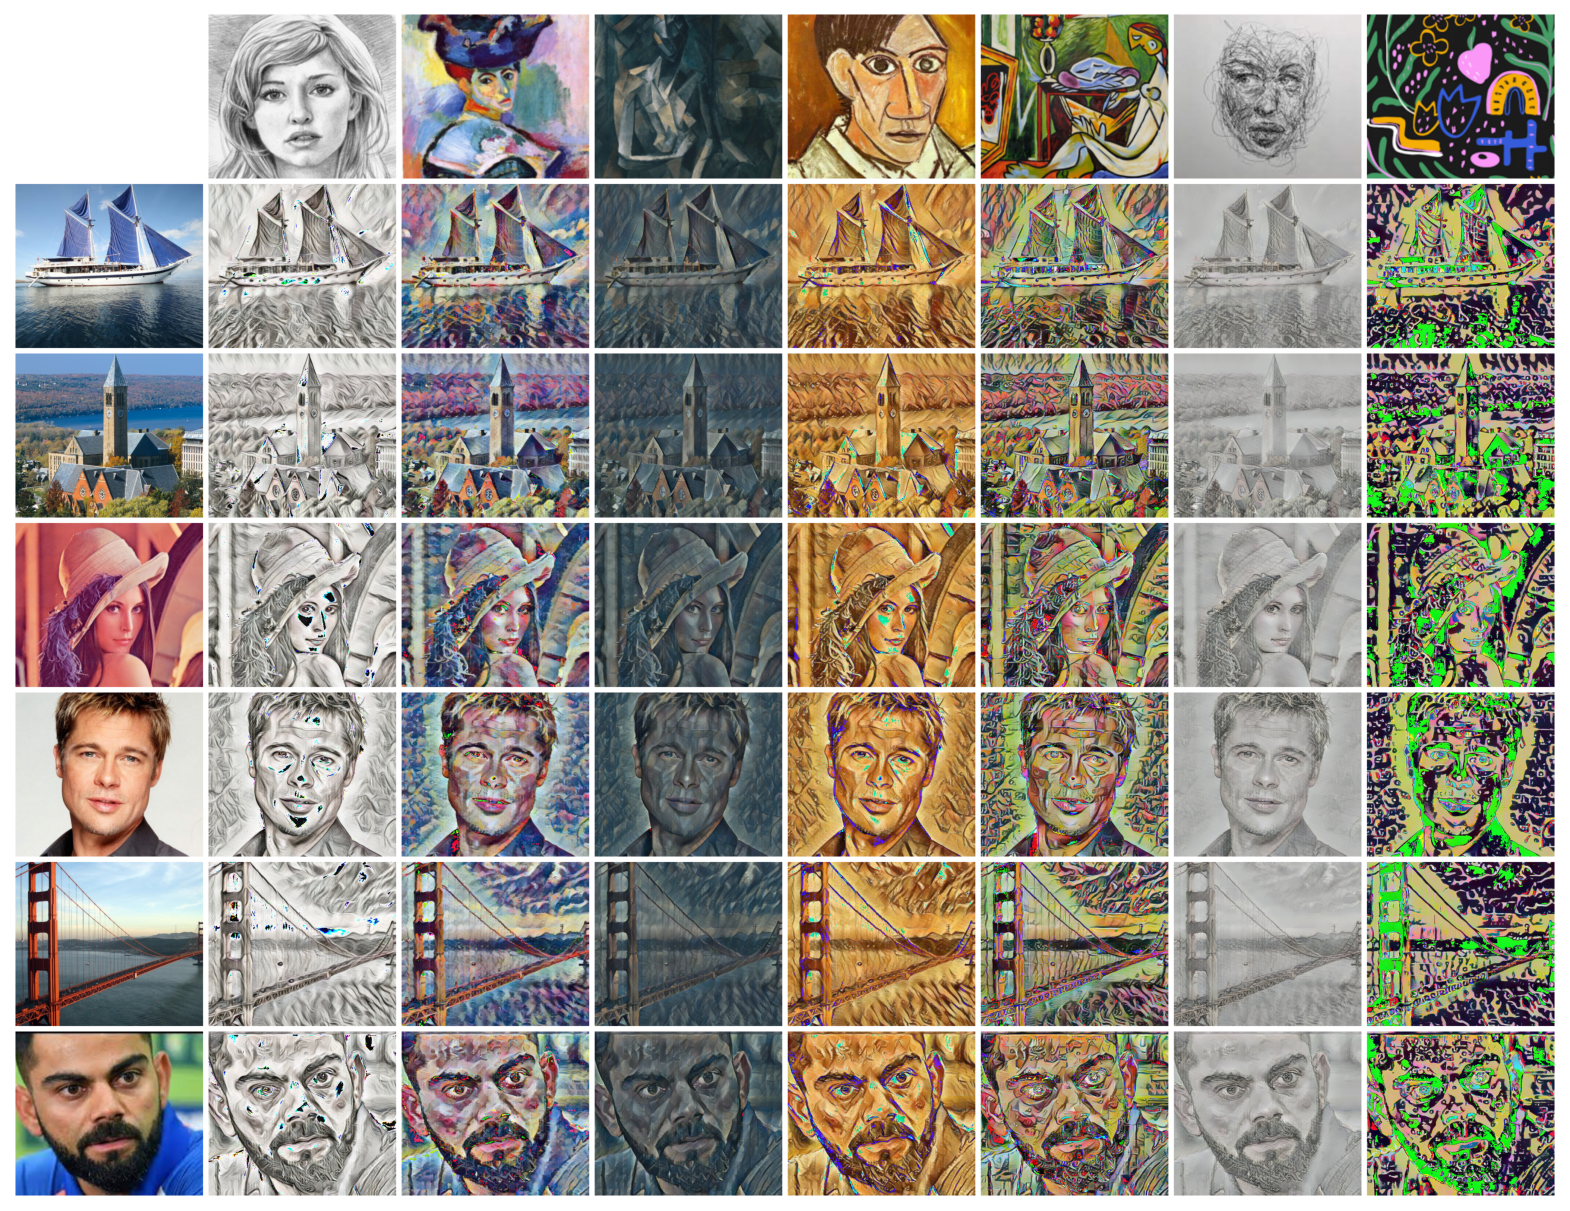

In [141]:

# Convert the torch tensor grid to a PIL Image
grid_pil = to_pil_image(grid)

# Display the grid using matplotlib
plt.figure(figsize=(20, 0))
plt.imshow(grid_pil)
plt.axis('off')
plt.show()


In [117]:
    iterations=1000
    log_dir = './'
    checkpoint= None
    val_interval=1000
    torch.cuda.empty_cache()
    gc.collect()

    #if args['checkpoint'] is None:
    max_epochs = 1
    model = LightningModel()
    #else:
        # We need to increment the max_epoch variable, because PyTorch Lightning will
        #   resume training from the beginning of the next epoch if resuming from a mid-epoch checkpoint.
     #   max_epochs = torch.load(args['checkpoint'])['epoch'] + 1
      #  model = LightningModel.load_from_checkpoint(checkpoint_path=args['checkpoint'])
    datamodule = DataModule()
    logger = TensorBoardImageLogger(save_dir = './', name='logs')
    lr_monitor = LearningRateMonitor(logging_interval='step')
    trainer = Trainer(accelerator='gpu',devices=1,
                      max_epochs=max_epochs,
                      max_steps=iterations, 
                      val_check_interval=val_interval,
                      logger=logger,
                      callbacks=[lr_monitor])
  
    trainer.test(model, datamodule=datamodule)

Validation DataLoader 0: : 1904it [03:51,  8.21it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.41it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Runningstage.testing metric      DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    test/loss_content       24.847352981567383
     test/loss_style        155.06272888183594
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test/loss_style': 155.06272888183594,
  'test/loss_content': 24.847352981567383}]

In [119]:
model.hparams

"alpha":          1.0
"content_loss":   mse
"content_weight": 1.0
"kernel_size":    3
"lr":             0.0001
"lr_decay":       5e-05
"model_type":     adaconv
"style_channels": 512
"style_loss":     mm
"style_size":     256
"style_weight":   10.0

# we are getting a loss_style(MomentMatching)=155 & loss_content(MSE)=24...These are  results judging content preservation and styling accuracy respective as well as you can see from above grid visual appeal are good.

improvements : run more iterations for better results. test on a larget dataset, use complex loss functions